# 6-2,训练模型的3种方法

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

下面以minist数据集的多分类模型的训练为例，演示这3种训练模型的风格。

其中类形式训练循环我们同时演示torchkeras.KerasModel和torchkeras.LightModel两种示范。


In [3]:
import torch 
import torchkeras
print("torch.__version__ = ", torch.__version__)
print("torchkeras.__version__ = ", torchkeras.__version__) 

torch.__version__ =  2.0.1
torchkeras.__version__ =  3.9.3


### 〇，准备数据

In [1]:
import torch 
from torch import nn 

import torchvision 
from torchvision import transforms


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="./data/mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="./data/mnist/",train=False,download=True,transform=transform)

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=4)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=4)

print(len(ds_train))
print(len(ds_val))


60000
10000


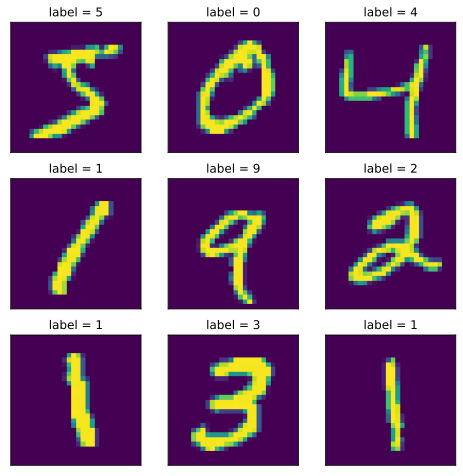

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

### 一，脚本风格

脚本风格的训练循环非常常见。

In [7]:
net = nn.Sequential()
net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("dropout",nn.Dropout2d(p = 0.1))
net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
net.add_module("flatten",nn.Flatten())
net.add_module("linear1",nn.Linear(64,32))
net.add_module("relu",nn.ReLU())
net.add_module("linear2",nn.Linear(32,10))

print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


```
Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)
```

In [11]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy
from torchmetrics import Accuracy


In [12]:
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=10)}

epochs = 20 
ckpt_path='checkpoint.pt'

#early_stopping相关设置
monitor="val_acc"
patience=5
mode="max"

history = {}

for epoch in range(1, epochs+1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，train -------------------------------------------------  
    net.train()
    
    total_loss,step = 0,0
    
    loop = tqdm(enumerate(dl_train), total =len(dl_train))
    train_metrics_dict = deepcopy(metrics_dict) 
    
    for i, batch in loop: 
        
        features,labels = batch
        #forward
        preds = net(features)
        loss = loss_fn(preds,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #metrics
        step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in train_metrics_dict.items()}
        
        step_log = dict({"train_loss":loss.item()},**step_metrics)

        total_loss += loss.item()
        
        step+=1
        if i!=len(dl_train)-1:
            loop.set_postfix(**step_log)
        else:
            epoch_loss = total_loss/step
            epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                             for name,metric_fn in train_metrics_dict.items()}
            epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
            loop.set_postfix(**epoch_log)

            for name,metric_fn in train_metrics_dict.items():
                metric_fn.reset()
                
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]
        

    # 2，validate -------------------------------------------------
    net.eval()
    
    total_loss,step = 0,0
    loop = tqdm(enumerate(dl_val), total =len(dl_val))
    
    val_metrics_dict = deepcopy(metrics_dict) 
    
    with torch.no_grad():
        for i, batch in loop: 

            features,labels = batch
            
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)

            #metrics
            step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in val_metrics_dict.items()}

            step_log = dict({"val_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            step+=1
            if i!=len(dl_val)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = (total_loss/step)
                epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in val_metrics_dict.items()}
                epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
                    
    epoch_log["epoch"] = epoch           
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，early-stopping -------------------------------------------------
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
    if best_score_idx==len(arr_scores)-1:
        torch.save(net.state_dict(),ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
             arr_scores[best_score_idx]),file=sys.stderr)
    if len(arr_scores)-best_score_idx>patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor,patience),file=sys.stderr)
        break 
    net.load_state_dict(torch.load(ckpt_path))
    
dfhistory = pd.DataFrame(history)



================================================================================2023-08-02 16:52:38
Epoch 1 / 20



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.64it/s, val_acc=0.976, val_loss=0.0822]


================================================================================2023-08-02 16:53:03
Epoch 2 / 20




<<<<<< reach best val_acc : 0.9758999943733215 >>>>>>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.63it/s, val_acc=0.979, val_loss=0.0773]


================================================================================2023-08-02 16:53:28
Epoch 3 / 20




<<<<<< reach best val_acc : 0.979200005531311 >>>>>>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.50it/s, val_acc=0.977, val_loss=0.0741]


================================================================================2023-08-02 16:53:53
Epoch 4 / 20




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.15it/s, val_acc=0.977, val_loss=0.0782]


================================================================================2023-08-02 16:54:18
Epoch 5 / 20




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.36it/s, val_acc=0.978, val_loss=0.0748]


================================================================================2023-08-02 16:54:44
Epoch 6 / 20




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.96it/s, val_acc=0.974, val_loss=0.0871]


================================================================================2023-08-02 16:55:09
Epoch 7 / 20




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.38it/s, val_acc=0.976, val_loss=0.0843]
<<<<<< val_acc without improvement in 5 epoch, early stopping >>>>>>


### 二，函数风格

该风格在脚本形式上做了进一步的函数封装。

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [14]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn,
                 stage = "train", metrics_dict = None, 
                 optimizer = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer = optimizer
            
    def step(self, features, labels):
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)
        
        #backward()
        if self.optimizer is not None and self.stage=="train": 
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics
    
    def train_step(self,features,labels):
        self.net.train() #训练模式, dropout层发生作用
        return self.step(features,labels)
    
    @torch.no_grad()
    def eval_step(self,features,labels):
        self.net.eval() #预测模式, dropout层不发生作用
        return self.step(features,labels)
    
    def __call__(self,features,labels):
        if self.stage=="train":
            return self.train_step(features,labels) 
        else:
            return self.eval_step(features,labels)
        
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop: 
            loss, step_metrics = self.steprunner(*batch)
            step_log = dict({self.stage+"_loss":loss},**step_metrics)
            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log


def train_model(net, optimizer, loss_fn, metrics_dict, 
                train_data, val_data=None, 
                epochs=10, ckpt_path='checkpoint.pt',
                patience=5, monitor="val_loss", mode="min"):
    
    history = {}

    for epoch in range(1, epochs+1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1，train -------------------------------------------------  
        train_step_runner = StepRunner(net = net,stage="train",
                loss_fn = loss_fn,metrics_dict=deepcopy(metrics_dict),
                optimizer = optimizer)
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)

        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2，validate -------------------------------------------------
        if val_data:
            val_step_runner = StepRunner(net = net,stage="val",
                loss_fn = loss_fn,metrics_dict=deepcopy(metrics_dict))
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

        # 3，early-stopping -------------------------------------------------
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
        if best_score_idx==len(arr_scores)-1:
            torch.save(net.state_dict(),ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                 arr_scores[best_score_idx]),file=sys.stderr)
        if len(arr_scores)-best_score_idx>patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                monitor,patience),file=sys.stderr)
            break 
        net.load_state_dict(torch.load(ckpt_path))

    return pd.DataFrame(history)


In [15]:
from torchmetrics import Accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=10)}

dfhistory = train_model(net,
    optimizer,
    loss_fn,
    metrics_dict,
    train_data = dl_train,
    val_data= dl_val,
    epochs=10,
    patience=3,
    monitor="val_acc", 
    mode="max")



================================================================================2023-08-02 16:58:14
Epoch 1 / 10



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.61it/s, val_acc=0.971, val_loss=0.0954]


================================================================================2023-08-02 16:58:39
Epoch 2 / 10




<<<<<< reach best val_acc : 0.97079998254776 >>>>>>
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.05it/s, val_acc=0.98, val_loss=0.0678]


================================================================================2023-08-02 16:59:04
Epoch 3 / 10




<<<<<< reach best val_acc : 0.9801999926567078 >>>>>>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.92it/s, val_acc=0.979, val_loss=0.0709]


================================================================================2023-08-02 16:59:29
Epoch 4 / 10




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.90it/s, val_acc=0.981, val_loss=0.0652]


================================================================================2023-08-02 16:59:54
Epoch 5 / 10




<<<<<< reach best val_acc : 0.9811999797821045 >>>>>>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.07it/s, val_acc=0.984, val_loss=0.0561]


================================================================================2023-08-02 17:00:20
Epoch 6 / 10




<<<<<< reach best val_acc : 0.9836000204086304 >>>>>>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.13it/s, val_acc=0.981, val_loss=0.0756]


================================================================================2023-08-02 17:00:46
Epoch 7 / 10




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.43it/s, val_acc=0.98, val_loss=0.0824]


================================================================================2023-08-02 17:01:11
Epoch 8 / 10




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.60it/s, val_acc=0.981, val_loss=0.0708]
<<<<<< val_acc without improvement in 3 epoch, early stopping >>>>>>


### 三，类风格

此处使用torchkeras.KerasModel高层次API接口中的fit方法训练模型。

使用该形式训练模型非常简洁明了。



In [4]:
from torchkeras import KerasModel 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
net = Net() 

print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


<<<<<< 🐌 cpu is used >>>>>>


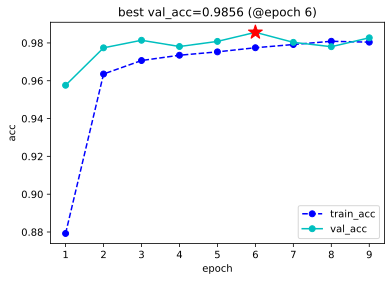

<<<<<< val_acc without improvement in 3 epoch,early stopping >>>>>> 



,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.368690,0.879217,0.01,0.140836,0.9576
1,2,0.120357,0.963550,0.01,0.082137,0.9774
2,3,0.099694,0.970683,0.01,0.063654,0.9814
3,4,0.088144,0.973483,0.01,0.078626,0.9781
4,5,0.084775,0.975267,0.01,0.071385,0.9808
5,6,0.080502,0.977450,0.01,0.051128,0.9856
6,7,0.076512,0.979150,0.01,0.072639,0.9803
7,8,0.067980,0.980867,0.01,0.090525,0.9780
8,9,0.073843,0.980400,0.01,0.067765,0.9827


In [5]:
from torchmetrics import Accuracy

model = KerasModel(net,
                   loss_fn=nn.CrossEntropyLoss(),
                   metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=10)},
                   optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)  )

model.fit(
    train_data = dl_train,
    val_data= dl_val,
    epochs=10,
    patience=3,
    monitor="val_acc", 
    mode="max",
    plot=True,
    cpu=True
)


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)